# Pooling before/after batch normalization

In this example, I would like to explore the possible effects of the order in which a pooling layer and a normalization layer are applied in convolutional neural networks.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Clase_3/Tarea_1

/content/drive/MyDrive/Clase_3/Tarea_1


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.utils import plot_model, to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import shuffle

## Building the data sets

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# take 10% as validation set
n_val = int(0.1*len(x_train))

x_val = x_train[:n_val]
x_train = x_train[n_val:]

y_val = y_train[:n_val]
y_train = y_train[n_val:]

print("Training: Data ({}), Labels ({})".format(x_train.shape, y_train.shape))
print("Validation: Data ({}), Labels ({})".format(x_val.shape, y_val.shape))
print("Testing: Data ({}), Labels ({})".format(x_test.shape, y_test.shape))

4431872/4422102 [==============================] - 0s 0us/step
Training: Data ((54000, 28, 28)), Labels ((54000, 10))
Validation: Data ((6000, 28, 28)), Labels ((6000, 10))
Testing: Data ((10000, 28, 28)), Labels ((10000, 10))


In [7]:
# (#,28,28) => (#,28,28,1)
# uint8 => float
# [0,255] => [0,1]
x_train = np.expand_dims(x_train, axis=-1).astype("float32")/255.0
x_val = np.expand_dims(x_val, axis=-1).astype("float32")/255.0
x_test = np.expand_dims(x_test, axis=-1).astype("float32")/255.0

In [8]:
name_labels = ['T-shirt/top', 
               'Trouser', 
               'Pullover', 
               'Dress', 
               'Coat', 
               'Sandal', 
               'Shirt', 
               'Sneaker', 
               'Bag', 
               'Ankle boot']

n_classes = len(name_labels)

In [9]:
batch_size = 64
# Generador para Entrenamiento, con flips horizontal y vertical
gen_train = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True)
# Generador para Validación
gen_val = ImageDataGenerator()

data_gen_train = gen_train.flow(x_train, y_train, batch_size=batch_size)
data_gen_val = gen_val.flow(x_val, y_val, batch_size=batch_size)

In [10]:
x_temp, y_tem = data_gen_train.next()
print(x_temp.shape, y_tem.shape)

(64, 28, 28, 1) (64, 10)


## Model APIs for both approaches

In [11]:
# Normalization before pooling
def get_model_norm_pool(filters, 
                        n_classes, 
                        k=3, 
                        name="my_model", 
                        padding="same", 
                        batch_norm=False, 
                        dropout=None):
    input_layer = Input(shape=(28,28,1))
    x = Conv2D(filters[0], (k,k), activation="relu", padding=padding)(input_layer)
    if batch_norm: x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    if dropout is not None: x = Dropout(dropout)(x)
    
    for n in filters[1:]:
        x = Conv2D(n, (k,k), activation="relu", padding=padding)(x)
        if batch_norm: x = BatchNormalization()(x)
        x = MaxPooling2D(2,2)(x)
        if dropout is not None: x = Dropout(dropout)(x)

    x = Flatten()(x)
    x = Dense(100, activation="relu")(x)
    output_layer = Dense(n_classes, activation="softmax")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer, name=name)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )
    return model

In [12]:
# Pooling before normalization
def get_model_pool_norm(filters, 
                        n_classes, 
                        k=3, 
                        name="my_model", 
                        padding="same", 
                        batch_norm=False, 
                        dropout=None):
    input_layer = Input(shape=(28,28,1))
    x = Conv2D(filters[0], (k,k), activation="relu", padding=padding)(input_layer)
    x = MaxPooling2D(2,2)(x)
    if batch_norm: x = BatchNormalization()(x)
    if dropout is not None: x = Dropout(dropout)(x)
    
    for n in filters[1:]:
        x = Conv2D(n, (k,k), activation="relu", padding=padding)(x)
        x = MaxPooling2D(2,2)(x)
        if batch_norm: x = BatchNormalization()(x)
        if dropout is not None: x = Dropout(dropout)(x)

    x = Flatten()(x)
    x = Dense(100, activation="relu")(x)
    output_layer = Dense(n_classes, activation="softmax")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer, name=name)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )
    return model

## Test 1: kernel = 3x3, pooling = 2x2, depths = [16, 32]

In [13]:
norm_bf_pool = get_model_norm_pool([16, 32], 
                                   n_classes, 
                                   name = "Norm_before_pooling", 
                                   batch_norm = True)

pool_bf_norm = get_model_pool_norm([16, 32], 
                                   n_classes, 
                                   name = "Pooling_before_norm", 
                                   batch_norm = True)

In [14]:
print("Model: {}, Parameters: {}".format(norm_bf_pool.name,
                                       norm_bf_pool.count_params()))

print("Model: {}, Parameters: {}".format(pool_bf_norm.name,
                                       pool_bf_norm.count_params()))


Model: Norm_before_pooling, Parameters: 162902
Model: Pooling_before_norm, Parameters: 162902


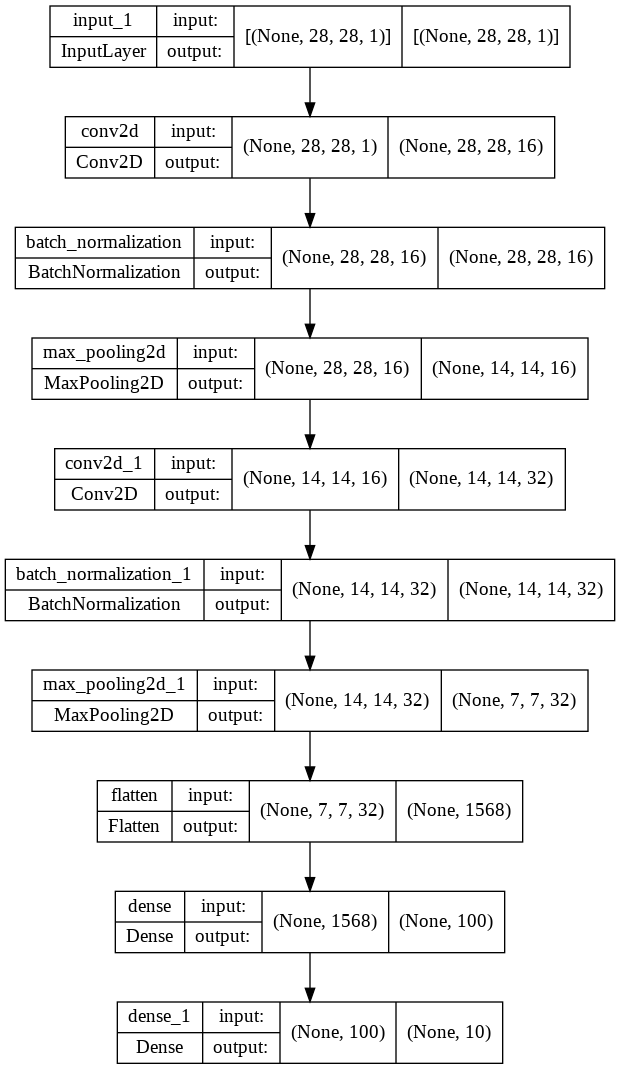

In [15]:
plot_model(norm_bf_pool, to_file="norm_bf_pool.png", show_shapes=True)

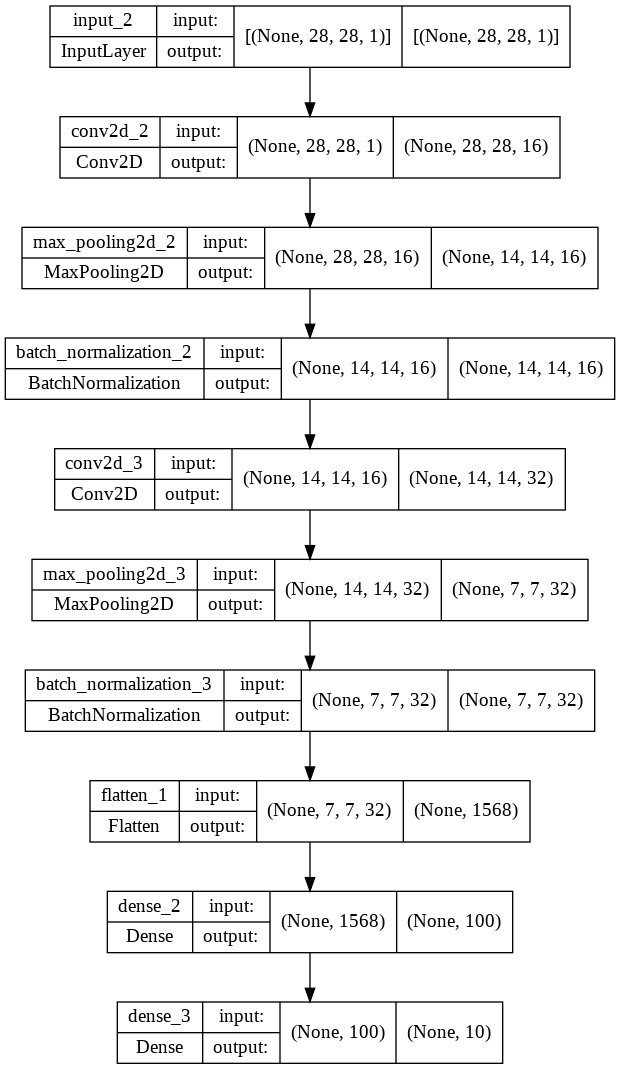

In [16]:
plot_model(pool_bf_norm, to_file="pool_bf_norm.png", show_shapes=True)

In [17]:
def get_ckpt(ckpt_name):
  return ModelCheckpoint(ckpt_name,
                         mode="max", 
                         save_best_only=True, 
                         monitor="val_accuracy", 
                         verbose=1)

In [18]:
# Callbacks
# ModelCheckpoint guardara el modelo cada vez que exista una mejora
# en el accuracy del conjunto de validación
mode_as_pool_bf_norm = get_ckpt("class_model_pool_bf_norm.h5")
mode_as_norm_bf_pool = get_ckpt("class_model_norm_bf_pool.h5")

# EarlyStopping terminara el entrenamiento si no existe una mejora
# en el accuracy en 40 epocas
early_stopping = EarlyStopping(patience=40, 
                               verbose=1, 
                               mode="auto")

callbacks_pool_bf_norm = [mode_as_pool_bf_norm, early_stopping]
callbacks_norm_bf_pool = [mode_as_norm_bf_pool, early_stopping]


In [19]:
history_norm_bf_pool = norm_bf_pool.fit(data_gen_train,epochs=200,validation_data=data_gen_val,callbacks=callbacks_norm_bf_pool)

Epoch 1/200
840/844 [============================>.] - ETA: 0s - loss: 0.4689 - accuracy: 0.8311
Epoch 1: val_accuracy improved from -inf to 0.88583, saving model to class_model_norm_bf_pool.h5
844/844 [==============================] - 16s 6ms/step - loss: 0.4681 - accuracy: 0.8314 - val_loss: 0.3242 - val_accuracy: 0.8858
Epoch 2/200
843/844 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8814
Epoch 2: val_accuracy improved from 0.88583 to 0.89500, saving model to class_model_norm_bf_pool.h5
844/844 [==============================] - 4s 5ms/step - loss: 0.3246 - accuracy: 0.8814 - val_loss: 0.2985 - val_accuracy: 0.8950
Epoch 3/200
839/844 [============================>.] - ETA: 0s - loss: 0.2851 - accuracy: 0.8957
Epoch 3: val_accuracy improved from 0.89500 to 0.90450, saving model to class_model_norm_bf_pool.h5
844/844 [==============================] - 4s 5ms/step - loss: 0.2848 - accuracy: 0.8958 - val_loss: 0.2703 - val_accuracy: 0.9045
Epoch 4/200
835/84

In [20]:
history_pool_bf_norm = pool_bf_norm.fit(data_gen_train,epochs=200,validation_data=data_gen_val,callbacks=callbacks_pool_bf_norm)

Epoch 1/200
835/844 [============================>.] - ETA: 0s - loss: 0.4579 - accuracy: 0.8346
Epoch 1: val_accuracy improved from -inf to 0.87667, saving model to class_model_pool_bf_norm.h5
844/844 [==============================] - 6s 6ms/step - loss: 0.4568 - accuracy: 0.8351 - val_loss: 0.3500 - val_accuracy: 0.8767
Epoch 2/200
842/844 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8817
Epoch 2: val_accuracy improved from 0.87667 to 0.89567, saving model to class_model_pool_bf_norm.h5
844/844 [==============================] - 4s 5ms/step - loss: 0.3216 - accuracy: 0.8816 - val_loss: 0.2910 - val_accuracy: 0.8957
Epoch 3/200
843/844 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8959
Epoch 3: val_accuracy did not improve from 0.89567
844/844 [==============================] - 4s 5ms/step - loss: 0.2830 - accuracy: 0.8959 - val_loss: 0.2840 - val_accuracy: 0.8947
Epoch 4/200
839/844 [============================>.] - ETA: 0s - los

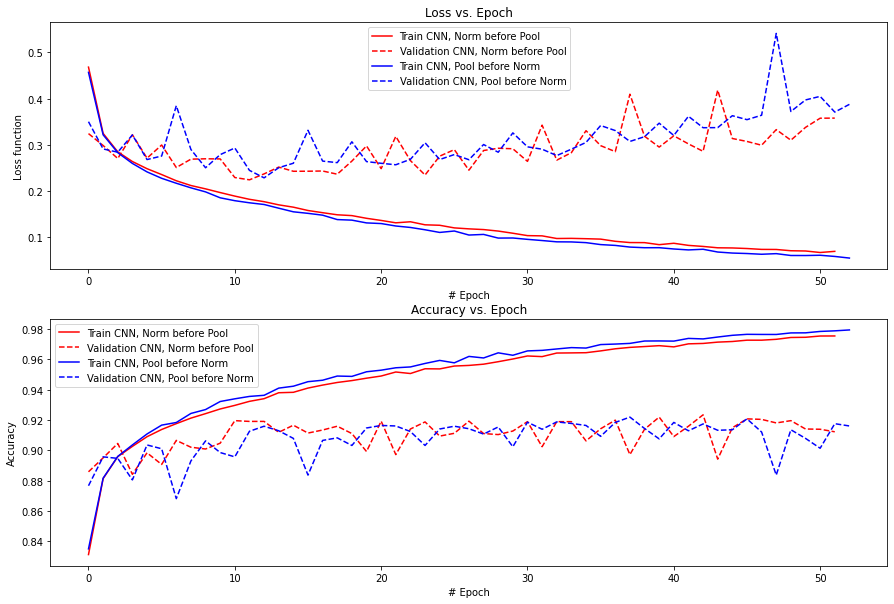

In [21]:
fig_labels = ["Train CNN, Norm before Pool", 
              "Validation CNN, Norm before Pool",              
              "Train CNN, Pool before Norm",
              "Validation CNN, Pool before Norm"]

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(history_norm_bf_pool.history["loss"], "r-")
plt.plot(history_norm_bf_pool.history["val_loss"], "r--")
plt.plot(history_pool_bf_norm.history["loss"], "b-")
plt.plot(history_pool_bf_norm.history["val_loss"], "b--")
plt.xlabel("# Epoch")
plt.ylabel("Loss function")
plt.legend(fig_labels)
plt.title("Loss vs. Epoch")

plt.subplot(2,1,2)
plt.plot(history_norm_bf_pool.history["accuracy"], "r-")
plt.plot(history_norm_bf_pool.history["val_accuracy"], "r--")
plt.plot(history_pool_bf_norm.history["accuracy"], "b-")
plt.plot(history_pool_bf_norm.history["val_accuracy"], "b--")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(fig_labels)
plt.title("Accuracy vs. Epoch")

plt.show()

In [22]:
gen_test = ImageDataGenerator()

data_gen_test = gen_train.flow(x_test, y_test, batch_size=batch_size)

In [23]:
print("Entrenamiento:")
scores_train_1 = norm_bf_pool.evaluate(data_gen_train)
scores_train_2 = pool_bf_norm.evaluate(data_gen_train)

print("Validación:")
scores_val_1 = norm_bf_pool.evaluate(data_gen_val)
scores_val_2 = pool_bf_norm.evaluate(data_gen_val)

print("Pruebas:")
scores_test_1 = norm_bf_pool.evaluate(data_gen_test)
scores_test_2 = pool_bf_norm.evaluate(data_gen_test)

Entrenamiento:
844/844 [==============================] - 3s 4ms/step - loss: 0.0619 - accuracy: 0.9776
Validación:
94/94 [==============================] - 0s 4ms/step - loss: 0.3875 - accuracy: 0.9160
Pruebas:
157/157 [==============================] - 1s 4ms/step - loss: 0.4459 - accuracy: 0.9086


|Loss |Entrenamiento |Validación | -  |Accuracy |Entrenamiento |Validación|
|-----|------|----------|------|----|---------|------|
|NBP|0.0732|0.3577|- |             |0.9739| 0.9122 |
|PBN|0.0619|0.3875|- |             |0.9776| 0.9160 |

|Loss |Pruebas| -|Accuracy |Pruebas|
|-----|-------|--|---------|------|
|NBP|0.4043 |- | |0.9095|
|PBN|0.4459|- | |0.9086|

## Test 2: kernel = 3x3, pooling = 2x2, depths = [16, 32, 64], droput = 0.3

In [24]:
norm_bf_pool2 = get_model_norm_pool([16, 32, 64], 
                                    n_classes, 
                                    name = "Norm_before_pooling", 
                                    batch_norm = True, 
                                    dropout = 0.3)

pool_bf_norm2 = get_model_pool_norm([16, 32, 64], 
                                    n_classes, 
                                    name = "Pooling_before_norm", 
                                    batch_norm = True, 
                                    dropout = 0.3)

In [26]:
print("Model: {}, Parameters: {}".format(pool_bf_norm2.name,
                                         pool_bf_norm2.count_params()))

print("Model: {}, Parameters: {}".format(pool_bf_norm2.name,
                                         pool_bf_norm2.count_params()))

Model: Pooling_before_norm, Parameters: 82454
Model: Pooling_before_norm, Parameters: 82454


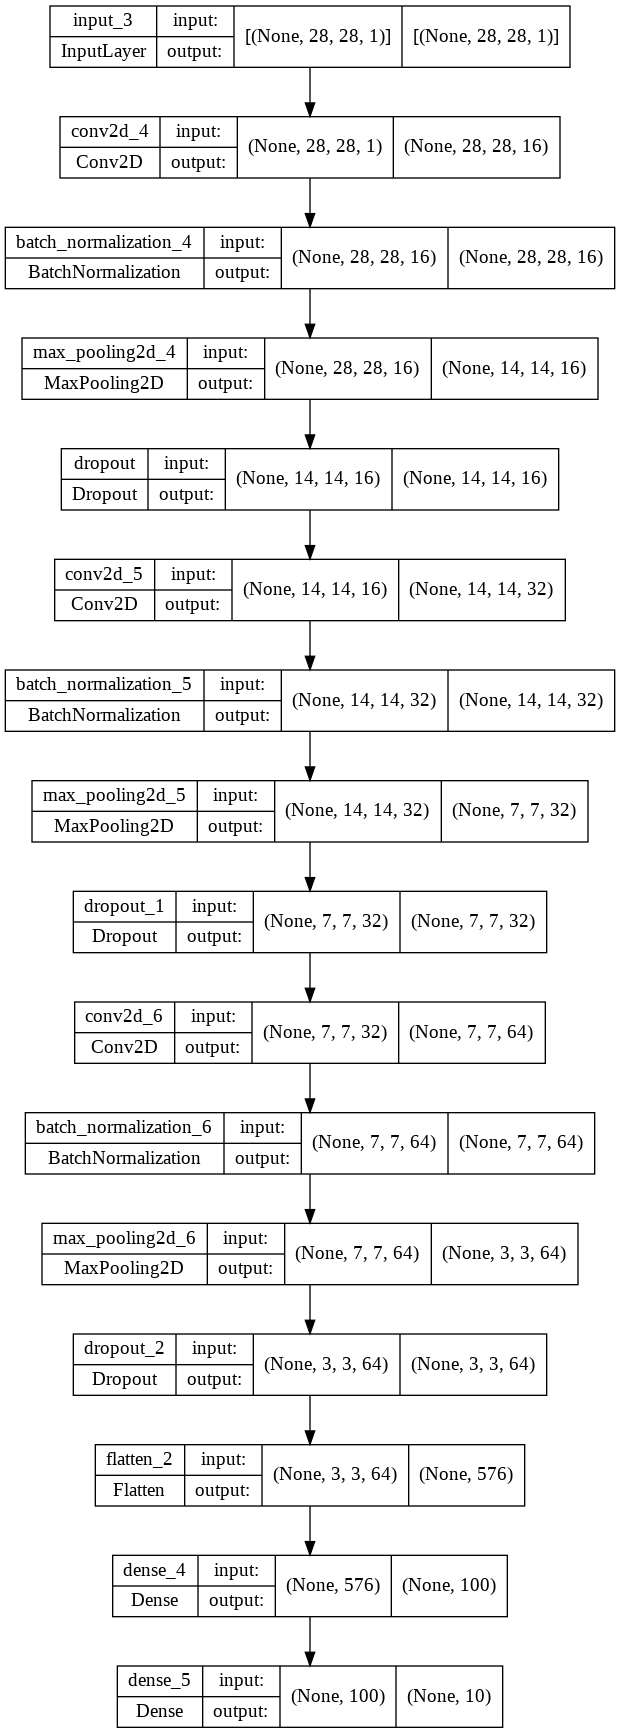

In [29]:
plot_model(norm_bf_pool2, to_file="norm_bf_pool2.png", show_shapes=True)

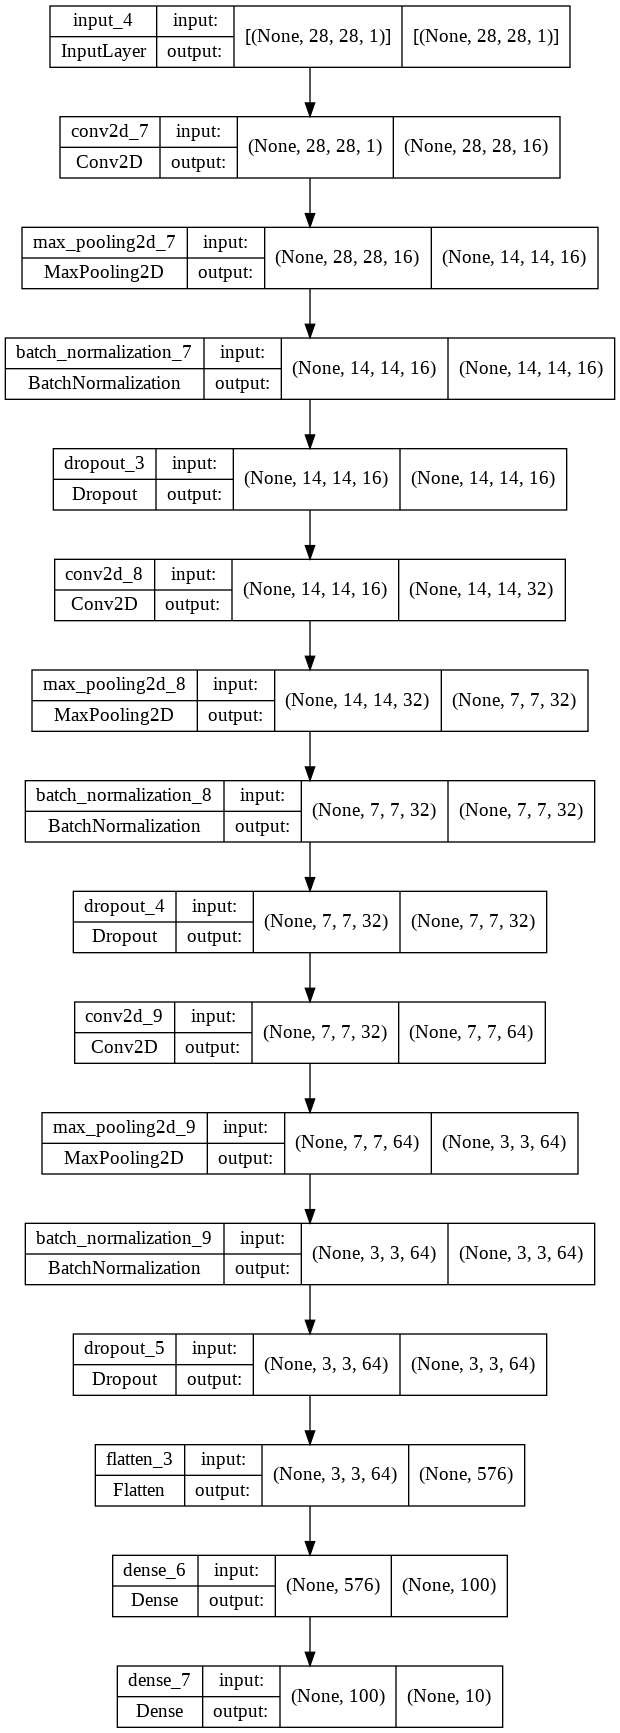

In [30]:
plot_model(pool_bf_norm2, to_file="pool_bf_norm2.png", show_shapes=True)

In [33]:
mode_as_pool_bf_norm2 = get_ckpt("class_model_pool_bf_norm2.h5")
mode_as_norm_bf_pool2 = get_ckpt("class_model_norm_bf_pool2.h5")

callbacks_pool_bf_norm2 = [mode_as_pool_bf_norm2, early_stopping]
callbacks_norm_bf_pool2 = [mode_as_norm_bf_pool2, early_stopping]

In [34]:
history_norm_bf_pool2 = norm_bf_pool2.fit(data_gen_train,epochs=200,validation_data=data_gen_val,callbacks=callbacks_norm_bf_pool2)

Epoch 1/200
838/844 [============================>.] - ETA: 0s - loss: 0.7527 - accuracy: 0.7204
Epoch 1: val_accuracy improved from -inf to 0.79650, saving model to class_model_norm_bf_pool2.h5
844/844 [==============================] - 6s 6ms/step - loss: 0.7514 - accuracy: 0.7207 - val_loss: 0.5223 - val_accuracy: 0.7965
Epoch 2/200
837/844 [============================>.] - ETA: 0s - loss: 0.5010 - accuracy: 0.8138
Epoch 2: val_accuracy improved from 0.79650 to 0.82850, saving model to class_model_norm_bf_pool2.h5
844/844 [==============================] - 5s 6ms/step - loss: 0.5002 - accuracy: 0.8139 - val_loss: 0.4504 - val_accuracy: 0.8285
Epoch 3/200
844/844 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.8402
Epoch 3: val_accuracy improved from 0.82850 to 0.87200, saving model to class_model_norm_bf_pool2.h5
844/844 [==============================] - 5s 6ms/step - loss: 0.4333 - accuracy: 0.8402 - val_loss: 0.3511 - val_accuracy: 0.8720
Epoch 4/200
836/

In [35]:
history_pool_bf_norm2 = pool_bf_norm2.fit(data_gen_train,epochs=200,validation_data=data_gen_val,callbacks=callbacks_pool_bf_norm2)

Epoch 1/200
837/844 [============================>.] - ETA: 0s - loss: 0.6751 - accuracy: 0.7503
Epoch 1: val_accuracy improved from -inf to 0.83433, saving model to class_model_pool_bf_norm2.h5
844/844 [==============================] - 6s 6ms/step - loss: 0.6737 - accuracy: 0.7509 - val_loss: 0.4468 - val_accuracy: 0.8343
Epoch 2/200
839/844 [============================>.] - ETA: 0s - loss: 0.4585 - accuracy: 0.8299
Epoch 2: val_accuracy improved from 0.83433 to 0.86600, saving model to class_model_pool_bf_norm2.h5
844/844 [==============================] - 5s 6ms/step - loss: 0.4586 - accuracy: 0.8299 - val_loss: 0.3565 - val_accuracy: 0.8660
Epoch 3/200
838/844 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.8472
Epoch 3: val_accuracy improved from 0.86600 to 0.86850, saving model to class_model_pool_bf_norm2.h5
844/844 [==============================] - 5s 6ms/step - loss: 0.4114 - accuracy: 0.8472 - val_loss: 0.3606 - val_accuracy: 0.8685
Epoch 4/200
836/

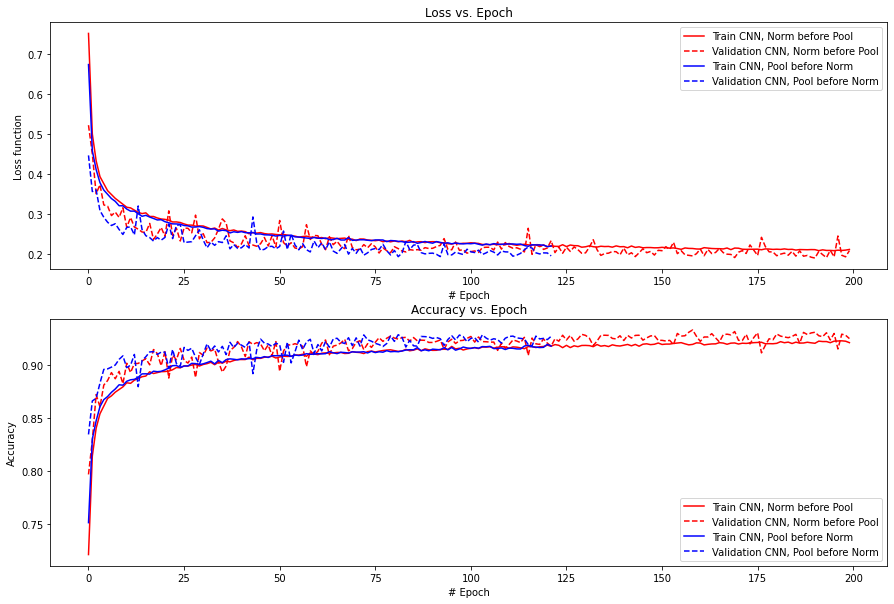

In [36]:
fig_labels = ["Train CNN, Norm before Pool", 
              "Validation CNN, Norm before Pool",              
              "Train CNN, Pool before Norm",
              "Validation CNN, Pool before Norm"]

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(history_norm_bf_pool2.history["loss"], "r-")
plt.plot(history_norm_bf_pool2.history["val_loss"], "r--")
plt.plot(history_pool_bf_norm2.history["loss"], "b-")
plt.plot(history_pool_bf_norm2.history["val_loss"], "b--")
plt.xlabel("# Epoch")
plt.ylabel("Loss function")
plt.legend(fig_labels)
plt.title("Loss vs. Epoch")

plt.subplot(2,1,2)
plt.plot(history_norm_bf_pool2.history["accuracy"], "r-")
plt.plot(history_norm_bf_pool2.history["val_accuracy"], "r--")
plt.plot(history_pool_bf_norm2.history["accuracy"], "b-")
plt.plot(history_pool_bf_norm2.history["val_accuracy"], "b--")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(fig_labels)
plt.title("Accuracy vs. Epoch")

plt.show()

In [37]:
gen_test = ImageDataGenerator()

data_gen_test = gen_train.flow(x_test, y_test, batch_size=batch_size)

In [38]:
print("Entrenamiento:")
scores_train_1 = norm_bf_pool2.evaluate(data_gen_train)
scores_train_2 = pool_bf_norm2.evaluate(data_gen_train)

print("Validación:")
scores_val_1 = norm_bf_pool2.evaluate(data_gen_val)
scores_val_2 = pool_bf_norm2.evaluate(data_gen_val)

print("Pruebas:")
scores_test_1 = norm_bf_pool2.evaluate(data_gen_test)
scores_test_2 = pool_bf_norm2.evaluate(data_gen_test)

Entrenamiento:
844/844 [==============================] - 3s 4ms/step - loss: 0.1590 - accuracy: 0.9413
Validación:
94/94 [==============================] - 0s 4ms/step - loss: 0.1959 - accuracy: 0.9272
Pruebas:
157/157 [==============================] - 1s 4ms/step - loss: 0.2205 - accuracy: 0.9217


|Loss |Entrenamiento |Validación | -  |Accuracy |Entrenamiento |Validación|
|-----|------|----------|------|----|---------|------|
|NBP|0.1596|0.2090|- |             |0.9402| 0.9250 |
|PBN|0.1590|0.1959|- |             |0.9413| 0.9272 |

|Loss |Pruebas| -|Accuracy |Pruebas|
|-----|-------|--|---------|------|
|NBP|0.2316 |- | |0.9182|
|PBN|0.2205|- | |0.9217|

We can see the dropout proceedure and the extra convolution layer both give us a better performance with every sample. In both cases, the model in which the the pooling layer is applied before normalization grows faster in accuracy and decreases faster in loss, before plateauing.